# Sampling and Signal Averaging

ใน module นี้ เราจะมาเรียนรู้เกี่ยวกับการประมวลผลสัญญาณ (signal processing) แบบพื้นฐานที่มีโอกาสพบเจอบ่อยๆ ในการประมวลผลและวิเคราะห์ข้อมูลทาง neuroscience เช่น electroencephalogram (EEG) โดยจะเน้นการเรียนรู้ผ่าน `SciPy`

**หมายเหตุ** ใน module นี้ เราจะใช้คำว่า signal แทนคำว่า สัญญาณ


In [1]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets  # ใช้สำหรับการทำ interactive display

np.random.seed(42)



กำหนดให้ $x$ เป็น signal ที่มีค่าเปลี่ยนไปขึ้นอยู่กับแกนเวลา (continuous-time signal) และ กำหนดให้ $x(t)$ คือค่าของ signal นั้นที่เวลา $t$

ในการเก็บข้อมูลจริง เราไม่สามารถเก็บค่าของ signal นี้ในทุก ๆ ช่วงเวลา $t$ ได้ เนื่องจากข้อจำกัดทางด้านทรัพยากร เราจึงพึ่งพาเก็บตัวอย่าง signal นี้แค่บางส่วน (เรียกว่า กระบวนการ sampling)
วิธีที่ตรงไปตรงมาที่สุดที่สำหรับการเก็บตัวอย่างก็คือการเก็บค่าของ $x$ ที่มีระยะห่างในแกนเวลาเท่า ๆ กัน ยกตัวอย่าง เช่น ถ้าเราเริ่มเก็บค่าของ $x$ ที่เวลา $t=0$ และเราเก็บค่าทุก ๆ วินาที (sampling period $T$ = 1s) เราจะได้ค่าของ signal $x$ ที่ประกอบด้วย $x(0), x(1), x(2), x(3), ...$

อัตราการเก็บข้อมูล (เช่น จำนวนจุดที่เก็บมาต่อวินาที) มีชื่อเรียกทางเทคนิคว่า sampling rate $f_s = 1/T$

หากเรากำหนด sampling rate $f_s$ เป็น $1/T$ Hz (ซึ่งแปลว่าเราเก็บข้อมูล 1 จุด ทุก ๆ $T$ วินาที)

ข้อมูลที่เราเก็บมาจะประกอบด้วยค่า $x(0), x(T), x(2T), x(3T), ..., x(nT)$

วิธีหนึ่งที่เป็นที่นิยมในการเขียนค่าที่เก็บมาไม่ให้ซับซ้อนจนเกินไปก็คือการเขียนแบบไม่ต้องมีค่า $T$ เช่น

*   เขียน $x[0]$ แทน $x(0*T)$
*   เขียน $x[1]$ แทน $x(1*T)$
*   เขียน $x[2]$ แทน $x(2*T)$
*   เขียน $x[3]$ แทน $x(3*T)$

สรุปเป็นสมการได้เป็น $x[n]=x(nT)$

---

ตัวอย่างด้านล่างแสดง continous time signal $x(t)=sin(2π20t)$ ด้วยสีน้ำเงิน และ จุดข้อมูลที่เก็บมา (discrete time signal) ด้วยสีแดง





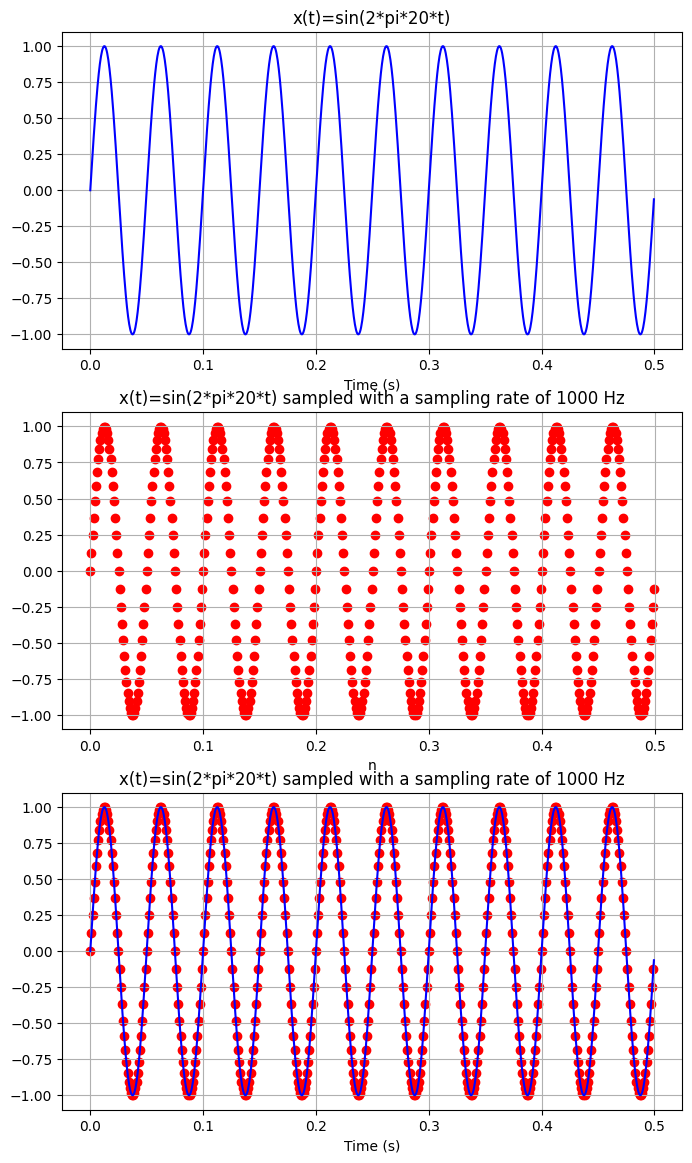

In [9]:
# ฟังก์ชันสำหรับสร้าง time signal ซึ่งเป็นฟังก์ชัน sine ที่มีความถี่ freq, มี sampling period คือ f_s และมีระยะเวลาในแกนเวลาเท่ากับ duration
def generate_sine_wave(freq, f_s, duration):

  # คำนวณค่า sampling period (ระยะห่างระหว่างจุดที่เก็บมาสองจุดในแกนเวลา)
  T = 1/f_s

  # คำนวณจำนวนจุดที่มีใน signal
  num_points = math.floor(f_s*duration)

  # สร้างแกนเวลา
  t = np.linspace(0.0, num_points*T, num_points, endpoint=False)

  # สร้าง signal x(t) = sin(2*pi*freq*t)
  x = np.sin(2*np.pi*freq*t)

  return x, t


freq_sine = 20 # ค่าความถี่ของฟังก์ชัน sine (Hz)
f_s = 1000 # อัตราการเก็บข้อมูล หรือ sampling rate (samples/s หรือ Hz)
duration = 0.5 # ระยะเวลาของ signal (s)

# สร้าง time signal ที่เป็นฟังก์ชัน sine ที่มีความถี่ 20 Hz โดยมีค่า sampling rate สูง เพื่อใช้เป็นตัวแทน continuous time signal
x_cont, t_cont = generate_sine_wave(freq=freq_sine, f_s=2000, duration=duration)

# สร้าง time signal ที่เป็นฟังก์ชัน sine ที่มีความถี่ 20 Hz เหมือนกันแต่ มีค่า sampling rate ต่ำลง แสดงถึง discrete time signal ที่เก็บมา
x_sampled, t_sampled = generate_sine_wave(freq=freq_sine, f_s=f_s, duration=duration)

# Plot x(t)
plt.figure(figsize = (8,14))
plt.subplot(3,1,1)
plt.plot(t_cont, x_cont, c='b')
plt.grid()
plt.xlabel('Time (s)')
plt.title(f"x(t)=sin(2*pi*20*t)")

# Plot x[n]
plt.subplot(3,1,2)
plt.scatter(t_sampled, x_sampled, c='r')
plt.grid()
plt.xlabel('n')
plt.title(f"x(t)=sin(2*pi*20*t) sampled with a sampling rate of {f_s} Hz")

# Plot ทั้ง x(t) และ x[n] ทับกัน
plt.subplot(3,1,3)
plt.plot(t_cont, x_cont, c='b', label='x(t)')
plt.scatter(t_sampled, x_sampled, c='r', label='x[n]')
plt.grid()
plt.xlabel('Time (s)')
plt.title(f"x(t)=sin(2*pi*20*t) sampled with a sampling rate of {f_s} Hz")
plt.show()



ในตัวอย่างด้านบน เราใช้ sampling rate ที่มีค่าสูง (จุดที่เก็บมีระยะห่างในแกนเวลาน้อย) ทำให้ค่าที่เก็บมา (จุดสีแดง) มีหน้าตาเหมือน continous time signal (เส้นสีน้ำเงิน) เลย

ด้วยค่า sampling rate ที่สูงเหมือนในกรณีนี้ ต่อให้เราไม่เคยเห็นเส้นสีน้ำเงินเลย เราก็ยังสามารถดูแค่ จุดสีแดง แล้วบอกได้เลยว่า signal นี้คือ sine wave ที่มีความถี่ 20 Hz

<br><br>

ในตัวอย่างถัดไป เราจะมาลองดูว่าถ้าเราเก็บข้อมูลด้วย sampling rate ที่น้อยลงเรื่อย ๆ (โดยที่ไม่เปลี่ยนค่าอื่นๆ เช่น ค่า duration = 0.5 s เหมือนเดิม) ข้อมูลที่เราได้รับจะมีหน้าตาเป็นอย่างไร

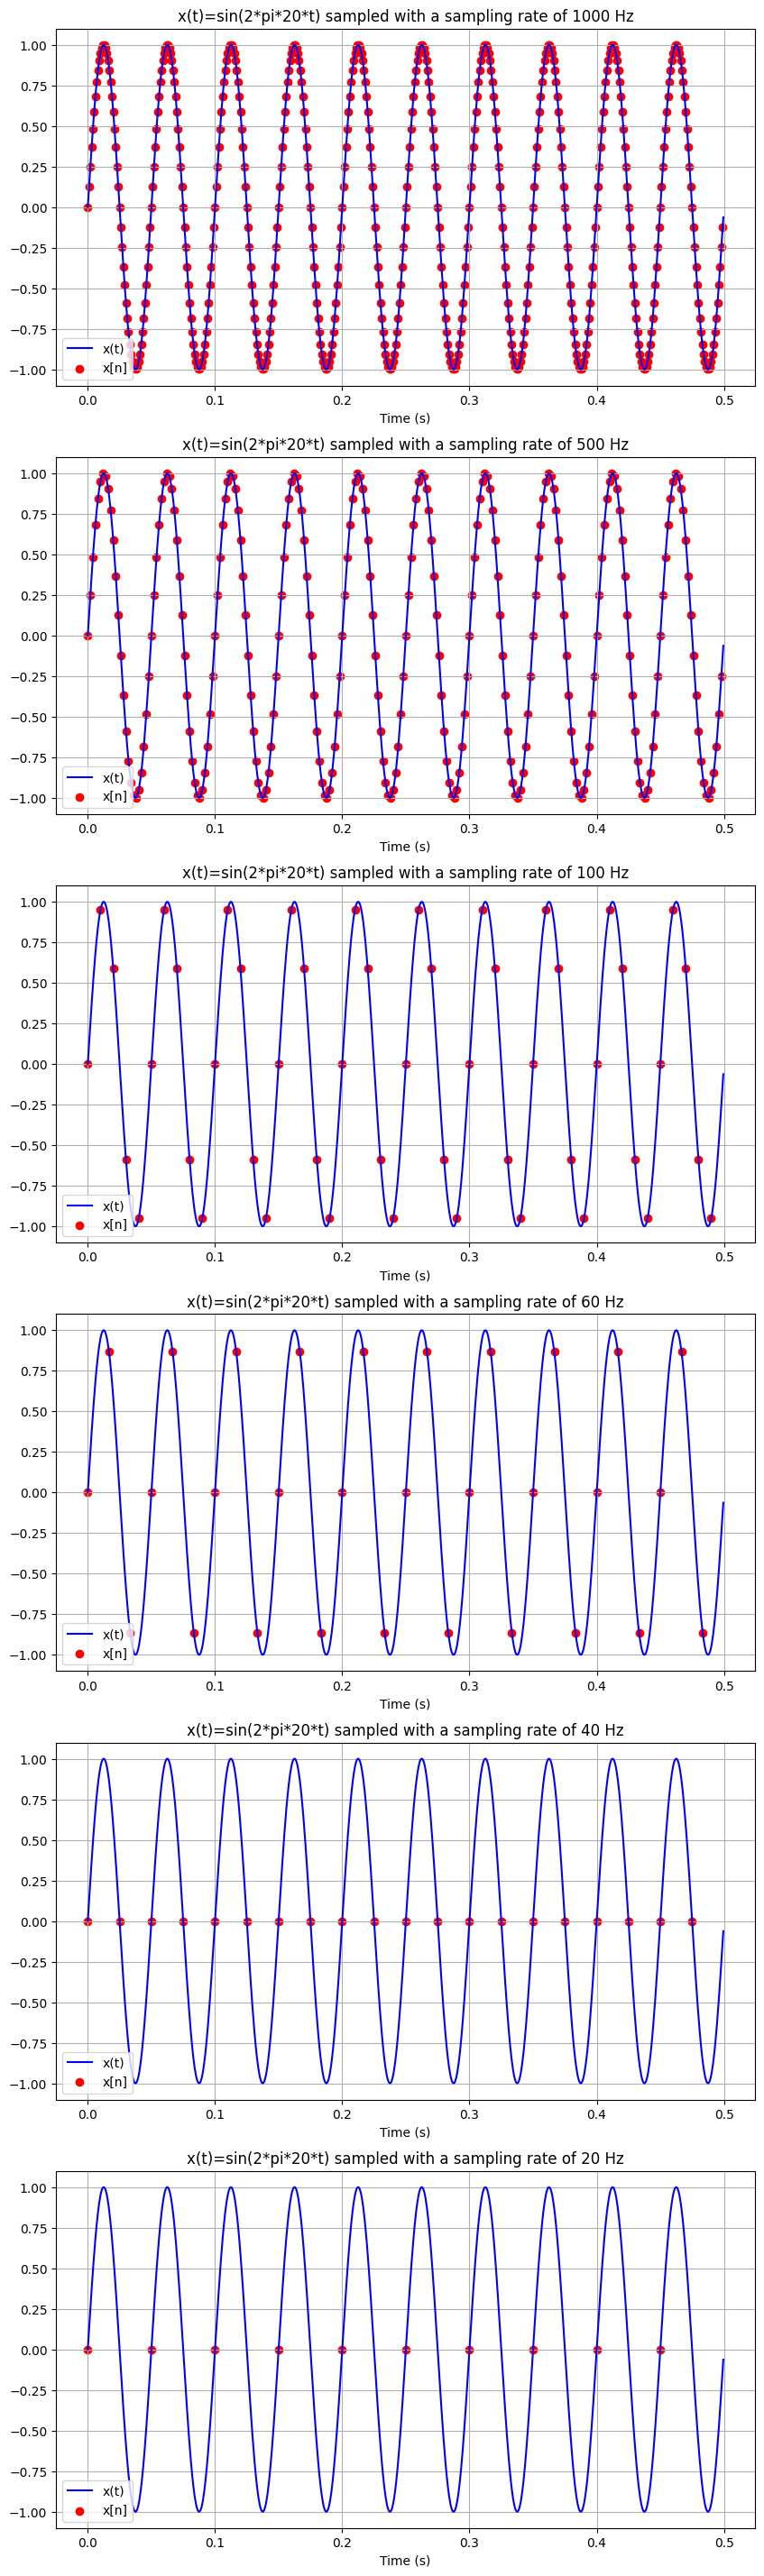

In [15]:
freq_sine = 20 # ค่าความถี่ของฟังก์ชัน sine (Hz)
f_s = 1000 # อัตราการเก็บข้อมูล หรือ sampling rate (samples/s หรือ Hz)
duration = 0.5 # ระยะเวลาของ signal (s)

# สร้าง time signal ที่เป็นฟังก์ชัน sine ที่มีความถี่ 20 Hz โดยมีค่า sampling rate สูง เพื่อใช้เป็นตัวแทน continuous time signal
x_cont, t_cont = generate_sine_wave(freq=freq_sine, f_s=2000, duration=duration)

f_s_list = [1000, 500, 100, 60, 40, 20] # สร้าง list ที่มีค่า sampling rate ที่ต้องการนำมาทดสอบ
num_sub_figs = len(f_s_list)

plt.figure(figsize=(10,6*num_sub_figs))
for count, f_s in enumerate(f_s_list, start=1):

  # สร้าง time signal ที่เป็นฟังก์ชัน sine ที่มีความถี่ 20 Hz เหมือนกัน โดยมีค่า sampling rate ที่กำหนดไว้ แสดงถึง discrete time signal ที่เก็บมา
  x_sampled, t_sampled = generate_sine_wave(freq=freq_sine, f_s=f_s, duration=duration)

  # กราฟทั้ง x(t) และ x[n] ทับกัน
  plt.subplot(num_sub_figs, 1, count)
  plt.plot(t_cont, x_cont, c='b', label='x(t)')
  plt.scatter(t_sampled, x_sampled, c='r', label='x[n]')
  plt.legend()
  plt.grid()
  plt.xlabel('Time (s)')
  plt.title(f"x(t)=sin(2*pi*20*t) sampled with a sampling rate of {f_s} Hz")
plt.show()

code ใน cell ถัดมา จะ plot ข้อมูลที่เราเก็บมาได้จาก signal อันเดิมโดยเราสามารถปรับค่า sampling rate ดูได้

In [19]:
def plot_interactive_fs_example():
    @widgets.interact(sampling_rate=widgets.BoundedIntText(1000, min=1, max=1000, description=f"f_s (Hz)"),
                      freq_wave=widgets.BoundedIntText(10, min=1, max=40, description=f"wave freq"),
                      show_cont_signal=widgets.Checkbox(True, description='Show continuous time signal'))
    def plot_sampled_signal(sampling_rate, freq_wave, show_cont_signal):

        duration = 0.5 # ระยะเวลาของ signal (s)

        # สร้าง time signal ที่เป็นฟังก์ชัน sine ที่มีความถี่เจาะจง โดยมีค่า sampling rate สูง เพื่อใช้เป็นตัวแทน continuous time signal
        x_cont, t_cont = generate_sine_wave(freq=freq_wave, f_s=2000, duration=duration)

        # สร้าง time signal ที่เป็นฟังก์ชัน sine ที่มีความถี่เจาะจง เหมือนกันแต่ มีค่า sampling rate สูง แสดงถึง discrete time signal ที่เก็บมา
        x_sampled, t_sampled = generate_sine_wave(freq=freq_wave, f_s=sampling_rate, duration=duration)

        # กราฟทั้ง x(t) และ x[n] ทับกัน
        plt.figure(figsize=(10,4))
        if show_cont_signal:
          plt.plot(t_cont, x_cont, c='b', label='x(t)')
        plt.scatter(t_sampled, x_sampled, c='r', label='x[n]')
        plt.legend()
        plt.grid()
        plt.xlabel('Time (s)')
        plt.title(f"x(t)=sin(2*pi*{freq_wave}*t) sampled with a sampling rate of {sampling_rate} Hz")
        plt.ylim(-1.25,1.25)
        plt.show()

plot_interactive_fs_example()

interactive(children=(BoundedIntText(value=1000, description='f_s (Hz)', max=1000, min=1), BoundedIntText(valu…

จากตัวอย่างด้านบนจะเห็นได้ว่า ยิ่งมี sampling rate ที่สูง discrete-time signal ที่เราเก็บมา (จุดสีแดง) ก็จะยิ่งมีหน้าตาเหมือนกับ signal จริง (เส้นสีน้ำเงิน) มากขึ้นเรื่อย ๆ แต่สิ่งที่เราต้องแลกมาในการใช้ sampling rate ที่สูงก็คือเราต้องใช้ทรัพยากรในการจัดเก็บข้อมูลมากขึ้น และถ้าหากเราต้องการวิเคราะห์ข้อมูล เราก็จะต้องใช้ทรัพยากรในการประมวลผลที่สูงขึ้นด้วยเช่นกัน

<br>

ในทางปฏิบัติ เราเลือก sampling rate ที่มีค่าน้อย (จำนวนจุดสีแดงน้อย) ในขณะที่ยังมากพอที่จะอนุมานหน้าตาของเส้นสีน้ำเงินได้อยู่

<br>

**หมายเหตุ** สำหรับผู้ที่สนใจ เราสามารถใช้ [The Nyquist-Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) ในการช่วยเลือกค่า sampling rate ที่ไม่น้อยจนเกินไปได้ โดยทั่วไปแล้ว เรามักจะเลือก sampling rate $f_s$ ให้มีค่าที่สูงกว่า 2 เท่าของความถี่ของ signal ที่เราสนใจ เช่น ถ้าเราต้องการศึกษาสัญญาณจากสมองที่มีชื่อว่าสัญญาณ alpha ซึ่งทางการแพทย์เราทราบว่ามีความถี่อยู่ระหว่าง 8 Hz ถึง 12 Hz เราก็ควรจะเก็บข้อมูลจากสมองที่มีค่า sampling rate อย่างน้อย 24 Hz (ในทางปฏิบัติ เครื่องมือสำหรับใช้วัดสัญญาณจากสมองจะมีค่า sampling rate ตั้งต้นที่สูงกว่านี้มาก ๆ เช่น เกิน 1000 ดังนั้น เราอาจจะไม่ต้องกังวลมากนัก)

Signal averaging
---
ในส่วนนี้ กำหนดให้


*   มีวัตถุปริศนาที่ปล่อยสัญญาณ $x(t)=sin(2π \times 20t)$ มาตลอดเวลา

*   เรามีอุปกรณ์วัดข้อมูลชนิดหนึ่งที่เราจะใช้วัดค่าจากวัตถุปริศนานี้ เพียงแต่อุปกรณ์นี้ค่อนข้างเก่ามาก ทำให้เวลาเก็บข้อมูลทีไร จะมีสัญญาณรบกวนเกิดขึ้นอยู่เสมอ กล่าวคือข้อมูลที่เราเก็บมาจะเป็น $x(t)=sin(2π \times 20t) + noise $ เสมอ

*  สัญญาณรบกวนเป็น Gaussian ที่มีค่าเฉลี่ย และ standard deviation คงที่


*   การเก็บข้อมูลด้วยอุปกรณ์วัดข้อมูลชนิดนี้เสียค่าใช้จ่ายน้อยมาก และ เราสามารถเปิดอุปกรณ์นี้ได้ทั้งวันทั้งคืน

code ด้านล่าง จะเป็น code ที่จำลองการเก็บข้อมูลในแต่ละครั้ง




In [21]:
def collect_one_signal_from_device():

  # สัญญาณจริงที่มาจากวัตถุปริศนา
  x_true, t_sampled = generate_sine_wave(freq=20, f_s=1000, duration=duration)

  # สร้างสัญญาณรบกวน (noise) แบบ Gaussian ที่มีค่าเฉลี่ยอยู่ที่ 0 และค่า standard deviation อยู่ที่ 0.5
  noise = normal(0, 0.5, size=x_true.shape)

  # สัญญาณที่เครื่องมือวัดของเราเก็บได้
  x_sampled_device = x_true + noise

  return x_sampled_device, x_true, t_sampled

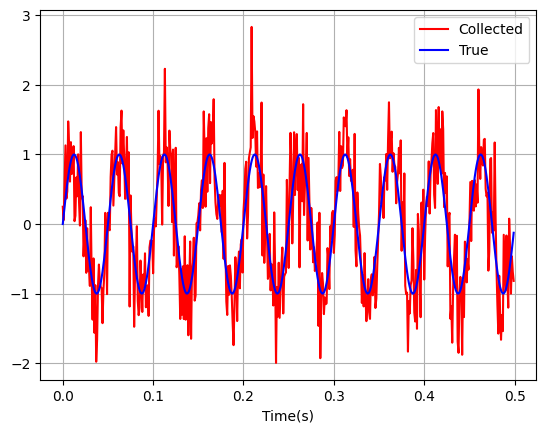

In [22]:
x_sampled_device, x_true, t_sampled = collect_one_signal_from_device()

plt.figure()
plt.plot(t_sampled, x_sampled_device, c='r', label='Collected')
plt.plot(t_sampled, x_true, c='b', label='True')
plt.xlabel('Time(s)')
plt.legend()
plt.grid()
plt.show()

จากตัวอย่างด้านบน จะเห็นว่า signal ที่เราเก็บมาจากอุปกรณ์ของเรา (สีแดง) มีค่าที่ค่อนข้างแตกต่างจากสัญญาณจริง (สีน้ำเงิน) ค่อนข้างมาก

วิธีการนึงที่จะช่วยทำให้สัญญาณรบกวนเหล่านี้มีค่าลดลง ก็คือการนำเอา signal ที่เราเก็บมาจากอุปกรณ์ของเราหลาย ๆ รอบ มาลองเฉลี่ยกัน

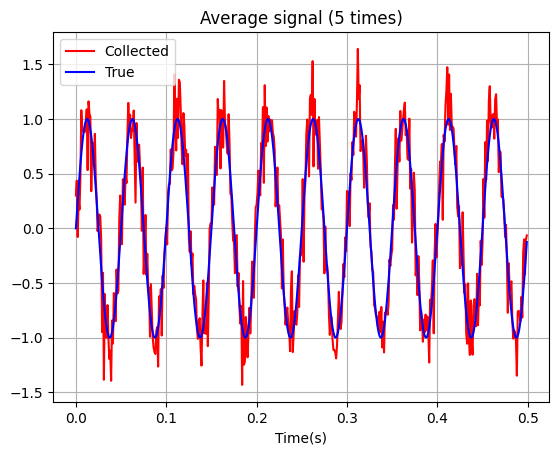

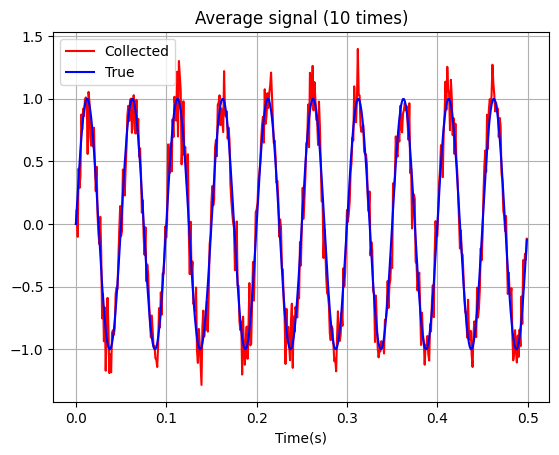

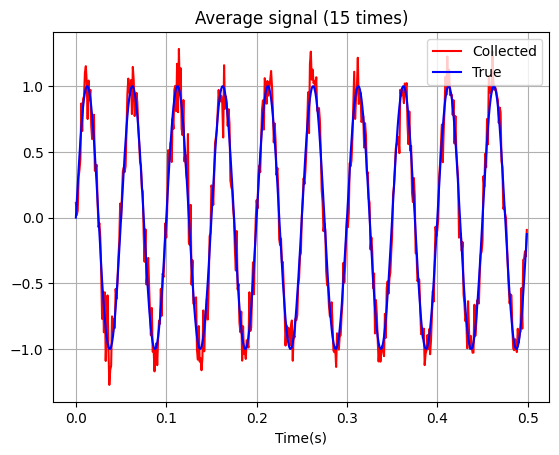

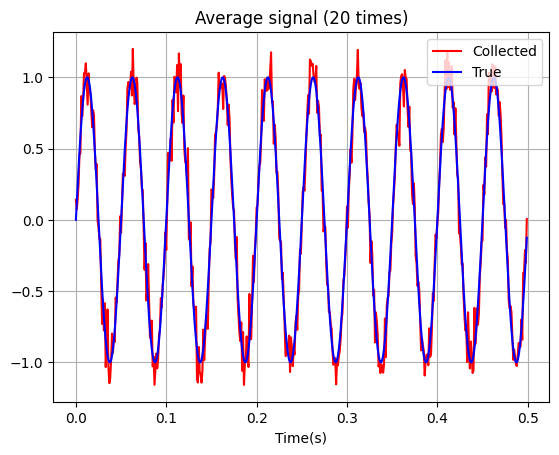

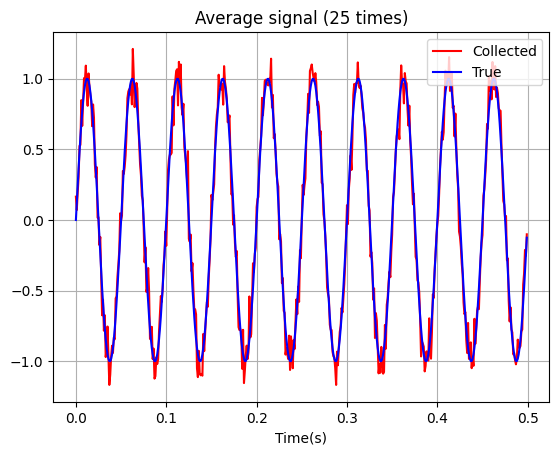

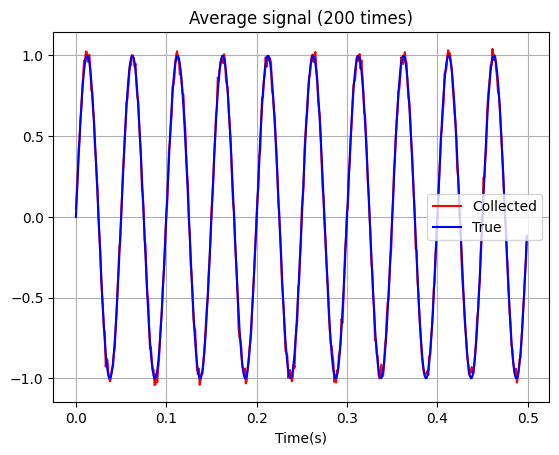

In [23]:
# จำนวนครั้งที่เก็บข้อมูล
num_collect = 200

# ตัวแปรสำหรับเก็บข้อมูลที่เกิดจากการเอา signal มาบวกกัน
x_sum = np.zeros_like(x_sampled_device)

for count in np.arange(1,num_collect+1):

  # เก็บข้อมูลแต่ละครั้ง
  x_sampled_device, x_true, t_sampled = collect_one_signal_from_device()

  # นำเอา signal ที่เก็บมาได้ในแต่ละครั้งมาบวกกัน
  x_sum += x_sampled_device

  # แสดงผลเป็นระยะๆ
  if count in [5, 10, 15, 20, 25, 200]:
    plt.figure()
    plt.plot(t_sampled, x_sum/count, c='r', label='Collected')
    plt.plot(t_sampled, x_true, c='b', label='True')
    plt.xlabel('Time(s)')
    plt.title(f"Average signal ({count} times)")
    plt.legend()
    plt.grid()
    plt.show()



จากตัวอย่างด้านบนจะเห็นได้ว่ายิ่งเราเก็บข้อมูลจากวัตถุปริศนานี้หลายๆรอบด้วยเครื่องมือเดิม และนำเอา signal ที่ได้นั้นมาเฉลี่ย (average) กัน จะพบว่าสัญญาณรบกวนจะค่อย ๆ หายไป ยิ่ง average มากขึ้น ก็จะยิ่งส่งผลให้สัญญาณรบกวนลดลงเรื่อย ๆ

In [24]:
@widgets.interact(n_avgs=widgets.BoundedIntText(1, min=1, max=500, description='# averages'))
def plot_sampled_signal(n_avgs):

    # สร้างข้อมูลที่ไม่มีสัญญาณรบกวน (clean signal)
    _, x_true, t_sampled = collect_one_signal_from_device()

    # ข้อมูลที่เกิดจากการเอา signal มาบวกกัน
    x_sum = np.zeros_like(x_true)

    for count in np.arange(1, n_avgs+1):

      # เก็บข้อมูลแต่ละครั้ง
      x_sampled_device, _, _ = collect_one_signal_from_device()

      # นำเอา signal ที่เก็บมาได้ในแต่ละครั้งมาบวกกัน
      x_sum += x_sampled_device

    # แสดงผลที่ average มาแล้ว
    plt.figure()
    plt.plot(t_sampled, x_sum/count, c='r', label='Collected')
    plt.plot(t_sampled, x_true, c='b', label='True')
    plt.xlabel('Time(s)')
    plt.title(f"Average signal ({count} times)")
    plt.legend()
    plt.grid()
    plt.ylim(-3,3)
    plt.show()


interactive(children=(BoundedIntText(value=1, description='# averages', max=500, min=1), Output()), _dom_class…

ข้อมูลทาง neuroscience หลายประเภท เช่น สัญญาณที่ได้จากเครื่อง electroencephalogram (EEG) เป็น signal ที่มีสัญญาณรบกวนมาก ดังนั้นการทำ signal averaging เป็นการประมวลผลแบบพื้นฐานของข้อมูลเหล่านี้ จึงได้รับความนิยมเป็นอย่างมาก

**หมายเหตุ** หากเราต้องการวัดคุณภาพของ signal เมื่อเปรียบเทียบกับปริมาณสัญญาณรบกวน ออกมาเป็นตัวเลข (quantitative metric) เราสามารถลอง metric แบบมาตรฐาน เช่น signal-to-noise ratio (SNR) หรือ Contrast-to-noise ratio (CNR) ได้